<span style="color:blue"> Бизнес-задача: 
- Предложить стратегию инвестиций в разработку игр, выявив связь между характеристиками игр (жанр, средний рейтинг, платформа) и их коммерческим успехом (продажи, выручка). </span>

In [493]:
# Импортируем необходимые для работы библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [494]:
games_rate_data = pd.read_csv('games.csv')
games_revenue_data = pd.read_csv('gamalytic_games.csv')

games_rate_data['esrb_rating'] = games_rate_data['esrb_rating'].fillna('No age rating')
games_rate_data = games_rate_data.rename(columns={'esrb_rating': 'age_rating'})

games_revenue = games_revenue_data.drop(columns=['steamId', 'unreleased', 'earlyAccess', 'publishers', 'headerUrl', 'steamUrl'])

games_rate_data

,name,released,rating,age_rating,genres,platforms
0,Grand Theft Auto V,2013-09-17,4.47,Mature,Action,"PC, PlayStation 5, Xbox Series S/X, PlayStatio..."
1,The Witcher 3: Wild Hunt,2015-05-18,4.64,Mature,"Action, RPG","PlayStation 5, Xbox Series S/X, macOS, PlaySta..."
2,Portal 2,2011-04-18,4.58,Everyone 10+,"Shooter, Puzzle","PlayStation 3, PC, Xbox 360, Linux, macOS, Xbo..."
3,Counter-Strike: Global Offensive,2012-08-21,3.57,Mature,Shooter,"PC, Linux, Xbox 360, PlayStation 3"
4,Tomb Raider (2013),2013-03-05,4.06,Mature,Action,"PlayStation 3, Xbox 360, macOS, PC, Xbox One, ..."
...,...,...,...,...,...,...
13995,Undefeated,2015-04-03,0.00,No age rating,"Action, Adventure, RPG, Strategy, Casual, Indie","PC, Android"
13996,NightmareZ,2016-09-08,0.00,No age rating,"Action, Indie",PC
13997,FERIT Simulator,2017-02-23,0.00,No age rating,Educational,PC
13998,BAD END,2013-12-13,2.17,Teen,"Adventure, Indie","iOS, PC"


In [495]:
print(games_rate_data['age_rating']) # Колонка не представляет ценности для анализа, удалим ее
games_rate_data = games_rate_data.drop(columns='age_rating')
games_rate_data

0               Mature
1               Mature
2         Everyone 10+
3               Mature
4               Mature
             ...      
13995    No age rating
13996    No age rating
13997    No age rating
13998             Teen
13999    No age rating
Name: age_rating, Length: 14000, dtype: object


,name,released,rating,genres,platforms
0,Grand Theft Auto V,2013-09-17,4.47,Action,"PC, PlayStation 5, Xbox Series S/X, PlayStatio..."
1,The Witcher 3: Wild Hunt,2015-05-18,4.64,"Action, RPG","PlayStation 5, Xbox Series S/X, macOS, PlaySta..."
2,Portal 2,2011-04-18,4.58,"Shooter, Puzzle","PlayStation 3, PC, Xbox 360, Linux, macOS, Xbo..."
3,Counter-Strike: Global Offensive,2012-08-21,3.57,Shooter,"PC, Linux, Xbox 360, PlayStation 3"
4,Tomb Raider (2013),2013-03-05,4.06,Action,"PlayStation 3, Xbox 360, macOS, PC, Xbox One, ..."
...,...,...,...,...,...
13995,Undefeated,2015-04-03,0.00,"Action, Adventure, RPG, Strategy, Casual, Indie","PC, Android"
13996,NightmareZ,2016-09-08,0.00,"Action, Indie",PC
13997,FERIT Simulator,2017-02-23,0.00,Educational,PC
13998,BAD END,2013-12-13,2.17,"Adventure, Indie","iOS, PC"


`Заметим, что есть строки в двух датасетах, где игры одинаковые, но названия имею различия, поэтому необходимо грамотно обработать такие случаи, чтобы впоследствии соединить датасеты`

In [496]:
import re

# Пишем функции для корректного сопоставления игр в двух датасетах
def clean(column):
    column = str(column).lower()
    column = re.sub(r'[^a-z0-9]', ' ', column)
    column = re.sub(r'\s+', ' ', column).strip()
    return column

def numeric_part(n):
    return ' '.join(re.findall(r'\d+', str(n)))

gd = games_rate_data.copy()
gr = games_revenue.copy()

gd['filter_name'] = gd['name'].apply(clean)
gr['filter_name'] = gr['name'].apply(clean)

gd = gd[gd['filter_name'] != '']
gr = gr[gr['filter_name'] != '']

gd['num_value'] = gd['filter_name'].apply(numeric_part)
gr['num_value'] = gr['filter_name'].apply(numeric_part)

joined = pd.merge(gr, gd, on=['filter_name', 'num_value'], how='inner', suffixes=('_rev', '_data'))

joined

,name_rev,firstReleaseDate,copiesSold,price,revenue,reviewScore,publisherClass,developers,filter_name,num_value,name_data,released,rating,genres,platforms
0,Counter-Strike 2,2012-05-01T00:00:00.000Z,324828766,0.00,9898329661,86,AAA,Valve,counter strike 2,2,Counter-Strike 2,2023-09-27,3.58,Shooter,"Linux, PC"
1,Dota 2,2011-08-01T00:00:00.000Z,213939465,0.00,2091450944,81,AAA,Valve,dota 2,2,Dota 2,2013-07-09,3.07,"Action, Massively Multiplayer","Linux, macOS, PC"
2,Apex Legends™,2020-11-04T05:00:00.000Z,72503084,0.00,1491767840,67,AAA,Respawn,apex legends,,Apex Legends,2019-02-04,3.64,"Action, Shooter","PlayStation 4, Nintendo Switch, macOS, PC, Xbo..."
3,Destiny 2,2019-10-01T04:00:00.000Z,38861886,0.00,901439163,78,AAA,Bungie,destiny 2,2,Destiny 2,2017-09-06,3.52,"Action, Shooter","PlayStation 4, Xbox One, PC, Web, Xbox Series ..."
4,Warframe,2013-03-25T04:00:00.000Z,47103348,0.00,879275446,87,AAA,Digital Extremes,warframe,,Warframe,2013-03-25,3.42,"Action, Shooter, RPG, Massively Multiplayer","iOS, Xbox Series S/X, PlayStation 5, PlayStati..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5711,Mirror Maker,2019-01-17T05:00:00.000Z,83137,1.99,65436,71,Indie,KAGAMI WORKs,mirror maker,,Mirror Maker,2019-01-24,1.75,"RPG, Simulation, Indie",PC
5712,Kromaia,2014-10-23T04:00:00.000Z,10378,9.99,65277,75,Indie,Kraken Empire,kromaia,,Kromaia,2014-10-22,0.00,"Action, Shooter, Arcade, Indie","PlayStation 4, PC"
5713,DUCATI - 90th Anniversary,2016-06-09T04:00:00.000Z,11258,9.99,65188,74,AA,Milestone S.r.l.,ducati 90th anniversary,90,DUCATI - 90th Anniversary,2016-06-09,2.60,"Simulation, Sports, Racing","PlayStation 4, PC, Xbox One"
5714,The Chaos Engine,2013-08-29T04:00:00.000Z,26117,9.99,65092,68,AA,"Abstraction Games,The Bitmap Brothers",the chaos engine,,The Chaos Engine,1993-03-01,3.67,"Action, Shooter","Atari ST, Classic Macintosh, SNES, Commodore /..."


In [497]:
joined = joined.drop(columns=['num_value', 'name_rev', 'filter_name']) # Удаляем лишние (дублирующие) столбцы для дальнейшей работы с данными
cols = list(joined.columns)

cols


['firstReleaseDate',
 'copiesSold',
 'price',
 'revenue',
 'reviewScore',
 'publisherClass',
 'developers',
 'name_data',
 'released',
 'rating',
 'genres',
 'platforms']

In [498]:
cols[0], cols[7] = cols[7], cols[0] # Восстанавливаем исходный порядок колонок
joined = joined[cols]

joined = joined.rename(columns={'name_data': 'name'}) # Возвращаем исходное название колонки

joined

,name,copiesSold,price,revenue,reviewScore,publisherClass,developers,firstReleaseDate,released,rating,genres,platforms
0,Counter-Strike 2,324828766,0.00,9898329661,86,AAA,Valve,2012-05-01T00:00:00.000Z,2023-09-27,3.58,Shooter,"Linux, PC"
1,Dota 2,213939465,0.00,2091450944,81,AAA,Valve,2011-08-01T00:00:00.000Z,2013-07-09,3.07,"Action, Massively Multiplayer","Linux, macOS, PC"
2,Apex Legends,72503084,0.00,1491767840,67,AAA,Respawn,2020-11-04T05:00:00.000Z,2019-02-04,3.64,"Action, Shooter","PlayStation 4, Nintendo Switch, macOS, PC, Xbo..."
3,Destiny 2,38861886,0.00,901439163,78,AAA,Bungie,2019-10-01T04:00:00.000Z,2017-09-06,3.52,"Action, Shooter","PlayStation 4, Xbox One, PC, Web, Xbox Series ..."
4,Warframe,47103348,0.00,879275446,87,AAA,Digital Extremes,2013-03-25T04:00:00.000Z,2013-03-25,3.42,"Action, Shooter, RPG, Massively Multiplayer","iOS, Xbox Series S/X, PlayStation 5, PlayStati..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5711,Mirror Maker,83137,1.99,65436,71,Indie,KAGAMI WORKs,2019-01-17T05:00:00.000Z,2019-01-24,1.75,"RPG, Simulation, Indie",PC
5712,Kromaia,10378,9.99,65277,75,Indie,Kraken Empire,2014-10-23T04:00:00.000Z,2014-10-22,0.00,"Action, Shooter, Arcade, Indie","PlayStation 4, PC"
5713,DUCATI - 90th Anniversary,11258,9.99,65188,74,AA,Milestone S.r.l.,2016-06-09T04:00:00.000Z,2016-06-09,2.60,"Simulation, Sports, Racing","PlayStation 4, PC, Xbox One"
5714,The Chaos Engine,26117,9.99,65092,68,AA,"Abstraction Games,The Bitmap Brothers",2013-08-29T04:00:00.000Z,1993-03-01,3.67,"Action, Shooter","Atari ST, Classic Macintosh, SNES, Commodore /..."


In [499]:
joined.isna().sum() # Смотрим на пропуски в данных

name                 0
copiesSold           0
price                0
revenue              0
reviewScore          0
publisherClass       0
developers          10
firstReleaseDate     0
released            81
rating               0
genres               4
platforms            0
dtype: int64

`Колонку released удаляем (не нужна), firstReleaseDate используем вместо нее далее, developers нигде не используем, тоже удаляем`

In [500]:
cleaned = joined[joined['rating'] != 0] # Удаляем строки (258 строк), где рейтинг равен 0, так как они не имеют ценности для анализа зависимости от выручки с игры
cleaned = cleaned.dropna(subset=['genres'])
cleaned = cleaned.reset_index()
cleaned = cleaned.drop(columns=['index', 'developers', 'released'])

cleaned


,name,copiesSold,price,revenue,reviewScore,publisherClass,firstReleaseDate,rating,genres,platforms
0,Counter-Strike 2,324828766,0.00,9898329661,86,AAA,2012-05-01T00:00:00.000Z,3.58,Shooter,"Linux, PC"
1,Dota 2,213939465,0.00,2091450944,81,AAA,2011-08-01T00:00:00.000Z,3.07,"Action, Massively Multiplayer","Linux, macOS, PC"
2,Apex Legends,72503084,0.00,1491767840,67,AAA,2020-11-04T05:00:00.000Z,3.64,"Action, Shooter","PlayStation 4, Nintendo Switch, macOS, PC, Xbo..."
3,Destiny 2,38861886,0.00,901439163,78,AAA,2019-10-01T04:00:00.000Z,3.52,"Action, Shooter","PlayStation 4, Xbox One, PC, Web, Xbox Series ..."
4,Warframe,47103348,0.00,879275446,87,AAA,2013-03-25T04:00:00.000Z,3.42,"Action, Shooter, RPG, Massively Multiplayer","iOS, Xbox Series S/X, PlayStation 5, PlayStati..."
...,...,...,...,...,...,...,...,...,...,...
5450,American Conquest,30326,4.99,65545,68,Indie,2011-08-27T04:00:00.000Z,3.68,Strategy,PC
5451,Mirror Maker,83137,1.99,65436,71,Indie,2019-01-17T05:00:00.000Z,1.75,"RPG, Simulation, Indie",PC
5452,DUCATI - 90th Anniversary,11258,9.99,65188,74,AA,2016-06-09T04:00:00.000Z,2.60,"Simulation, Sports, Racing","PlayStation 4, PC, Xbox One"
5453,The Chaos Engine,26117,9.99,65092,68,AA,2013-08-29T04:00:00.000Z,3.67,"Action, Shooter","Atari ST, Classic Macintosh, SNES, Commodore /..."


In [501]:
cleaned.dtypes

name                 object
copiesSold            int64
price               float64
revenue               int64
reviewScore           int64
publisherClass       object
firstReleaseDate     object
rating              float64
genres               object
platforms            object
dtype: object

`name - название игры`

`copiesSold - (вещественный) количество проданных копий`

`price - (вещественный) цена игры`

`revenue - (вещественный) выручка, является ЦЕЛЕВОЙ ПЕРЕМЕННОЙ`

`reviewScore - (вещественный) средняя оценка пользователей`

`publisherClass - (порядковый) тип издателя (AAA, AA, Indie, Hobbyist)`

`developers - (категориальный) студия разработки`

`firstReleaseDate - (текстовый, позже приведён к datetime) дата первого релиза игры`

`rating - (вещественный) средняя оценка пользователя на сайте rawg`

`genres - (категориалный) жанр игры`

`platforms - (категориальный) платформы, на которых выпущена игра`

<span style="color:green"> Классы издателей (Publisher Classes):

Hobbyist — издатели, заработавшие меньше $10 000 за всё время на Steam.

Indie — издатели, заработавшие от $10 000 до $50 млн за всё время на Steam.

AA — издатели, выпустившие как минимум 2 игры, с общим доходом от $50 млн до $500 млн.

AAA — издатели, выпустившие как минимум 2 игры, с общим доходом более $500 млн и средним доходом не менее $10 млн на игру.<span>

In [502]:
one_hotted_platforms = cleaned['platforms'].str.get_dummies(sep=', ') # Применяем one-hot encoding для сепарирования платформ и анализа конкретно интересующих (популярных)
one_hotted_platforms.columns

Index(['3DO', 'Android', 'Apple II', 'Atari ST', 'Classic Macintosh',
       'Commodore / Amiga', 'Dreamcast', 'Game Boy', 'Game Boy Advance',
       'Game Boy Color', 'Game Gear', 'GameCube', 'Genesis', 'Jaguar', 'Linux',
       'NES', 'Neo Geo', 'Nintendo 3DS', 'Nintendo 64', 'Nintendo DS',
       'Nintendo DSi', 'Nintendo Switch', 'PC', 'PS Vita', 'PSP',
       'PlayStation', 'PlayStation 2', 'PlayStation 3', 'PlayStation 4',
       'PlayStation 5', 'SEGA 32X', 'SEGA CD', 'SEGA Master System',
       'SEGA Saturn', 'SNES', 'Web', 'Wii', 'Wii U', 'Xbox', 'Xbox 360',
       'Xbox One', 'Xbox Series S/X', 'iOS', 'macOS'],
      dtype='object')

In [503]:
one_hotted_genres = cleaned['genres'].str.get_dummies(sep=', ') # Применяем one-hot encoding для сепарирования жанров
one_hotted_genres.columns

Index(['Action', 'Adventure', 'Arcade', 'Board Games', 'Card', 'Casual',
       'Educational', 'Family', 'Fighting', 'Indie', 'Massively Multiplayer',
       'Platformer', 'Puzzle', 'RPG', 'Racing', 'Shooter', 'Simulation',
       'Sports', 'Strategy'],
      dtype='object')

In [504]:
cleaned = pd.concat([cleaned, one_hotted_genres, one_hotted_platforms], axis=1)
cleaned

,name,copiesSold,price,revenue,reviewScore,publisherClass,firstReleaseDate,rating,genres,platforms,...,SNES,Web,Wii,Wii U,Xbox,Xbox 360,Xbox One,Xbox Series S/X,iOS,macOS
0,Counter-Strike 2,324828766,0.00,9898329661,86,AAA,2012-05-01T00:00:00.000Z,3.58,Shooter,"Linux, PC",...,0,0,0,0,0,0,0,0,0,0
1,Dota 2,213939465,0.00,2091450944,81,AAA,2011-08-01T00:00:00.000Z,3.07,"Action, Massively Multiplayer","Linux, macOS, PC",...,0,0,0,0,0,0,0,0,0,1
2,Apex Legends,72503084,0.00,1491767840,67,AAA,2020-11-04T05:00:00.000Z,3.64,"Action, Shooter","PlayStation 4, Nintendo Switch, macOS, PC, Xbo...",...,0,0,0,0,0,0,1,0,0,1
3,Destiny 2,38861886,0.00,901439163,78,AAA,2019-10-01T04:00:00.000Z,3.52,"Action, Shooter","PlayStation 4, Xbox One, PC, Web, Xbox Series ...",...,0,1,0,0,0,0,1,1,0,0
4,Warframe,47103348,0.00,879275446,87,AAA,2013-03-25T04:00:00.000Z,3.42,"Action, Shooter, RPG, Massively Multiplayer","iOS, Xbox Series S/X, PlayStation 5, PlayStati...",...,0,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450,American Conquest,30326,4.99,65545,68,Indie,2011-08-27T04:00:00.000Z,3.68,Strategy,PC,...,0,0,0,0,0,0,0,0,0,0
5451,Mirror Maker,83137,1.99,65436,71,Indie,2019-01-17T05:00:00.000Z,1.75,"RPG, Simulation, Indie",PC,...,0,0,0,0,0,0,0,0,0,0
5452,DUCATI - 90th Anniversary,11258,9.99,65188,74,AA,2016-06-09T04:00:00.000Z,2.60,"Simulation, Sports, Racing","PlayStation 4, PC, Xbox One",...,0,0,0,0,0,0,1,0,0,0
5453,The Chaos Engine,26117,9.99,65092,68,AA,2013-08-29T04:00:00.000Z,3.67,"Action, Shooter","Atari ST, Classic Macintosh, SNES, Commodore /...",...,1,0,0,0,0,0,0,0,0,1


In [505]:
cleaned['platforms_count'] = cleaned.loc[:, 'PC':'Xbox Series S/X'].sum(axis=1)
cleaned

,name,copiesSold,price,revenue,reviewScore,publisherClass,firstReleaseDate,rating,genres,platforms,...,Web,Wii,Wii U,Xbox,Xbox 360,Xbox One,Xbox Series S/X,iOS,macOS,platforms_count
0,Counter-Strike 2,324828766,0.00,9898329661,86,AAA,2012-05-01T00:00:00.000Z,3.58,Shooter,"Linux, PC",...,0,0,0,0,0,0,0,0,0,1
1,Dota 2,213939465,0.00,2091450944,81,AAA,2011-08-01T00:00:00.000Z,3.07,"Action, Massively Multiplayer","Linux, macOS, PC",...,0,0,0,0,0,0,0,0,1,1
2,Apex Legends,72503084,0.00,1491767840,67,AAA,2020-11-04T05:00:00.000Z,3.64,"Action, Shooter","PlayStation 4, Nintendo Switch, macOS, PC, Xbo...",...,0,0,0,0,0,1,0,0,1,3
3,Destiny 2,38861886,0.00,901439163,78,AAA,2019-10-01T04:00:00.000Z,3.52,"Action, Shooter","PlayStation 4, Xbox One, PC, Web, Xbox Series ...",...,1,0,0,0,0,1,1,0,0,6
4,Warframe,47103348,0.00,879275446,87,AAA,2013-03-25T04:00:00.000Z,3.42,"Action, Shooter, RPG, Massively Multiplayer","iOS, Xbox Series S/X, PlayStation 5, PlayStati...",...,0,0,0,0,0,1,1,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450,American Conquest,30326,4.99,65545,68,Indie,2011-08-27T04:00:00.000Z,3.68,Strategy,PC,...,0,0,0,0,0,0,0,0,0,1
5451,Mirror Maker,83137,1.99,65436,71,Indie,2019-01-17T05:00:00.000Z,1.75,"RPG, Simulation, Indie",PC,...,0,0,0,0,0,0,0,0,0,1
5452,DUCATI - 90th Anniversary,11258,9.99,65188,74,AA,2016-06-09T04:00:00.000Z,2.60,"Simulation, Sports, Racing","PlayStation 4, PC, Xbox One",...,0,0,0,0,0,1,0,0,0,3
5453,The Chaos Engine,26117,9.99,65092,68,AA,2013-08-29T04:00:00.000Z,3.67,"Action, Shooter","Atari ST, Classic Macintosh, SNES, Commodore /...",...,0,0,0,0,0,0,0,0,1,2


In [506]:
main_columns = ['name', 'copiesSold', 'price', 'revenue', 'publisherClass', 'firstReleaseDate', 'rating', 'platforms_count']
genres = ['Action', 'Adventure', 'Arcade', 'Board Games', 'Card', 'Casual', 'Educational', 'Family', 'Fighting', 'Indie', 'Massively Multiplayer', 'Platformer', 'Puzzle', 'RPG', 'Racing', 'Shooter', 'Simulation', 'Sports', 'Strategy']
prefers_platforms = ['PC', 'Android', 'iOS', 'macOS', 'Nintendo Switch', 'PlayStation 4', 'PlayStation 5', 'Xbox One', 'Xbox Series S/X'] # Берем только игры, выпущенные на самых популярных платформах

main_df = cleaned[main_columns + genres + prefers_platforms].copy() # Выделяем необходимые нам признаки

main_df['firstReleaseDate'] = pd.to_datetime(main_df['firstReleaseDate']).dt.year.astype('int') # Изменяем тип признака в формат времени

main_df # Далее работаем с этим очищенным датасетом

,name,copiesSold,price,revenue,publisherClass,firstReleaseDate,rating,platforms_count,Action,Adventure,...,Strategy,PC,Android,iOS,macOS,Nintendo Switch,PlayStation 4,PlayStation 5,Xbox One,Xbox Series S/X
0,Counter-Strike 2,324828766,0.00,9898329661,AAA,2012,3.58,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Dota 2,213939465,0.00,2091450944,AAA,2011,3.07,1,1,0,...,0,1,0,0,1,0,0,0,0,0
2,Apex Legends,72503084,0.00,1491767840,AAA,2020,3.64,3,1,0,...,0,1,0,0,1,1,1,0,1,0
3,Destiny 2,38861886,0.00,901439163,AAA,2019,3.52,6,1,0,...,0,1,0,0,0,0,1,1,1,1
4,Warframe,47103348,0.00,879275446,AAA,2013,3.42,5,1,0,...,0,1,0,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450,American Conquest,30326,4.99,65545,Indie,2011,3.68,1,0,0,...,1,1,0,0,0,0,0,0,0,0
5451,Mirror Maker,83137,1.99,65436,Indie,2019,1.75,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5452,DUCATI - 90th Anniversary,11258,9.99,65188,AA,2016,2.60,3,0,0,...,0,1,0,0,0,0,1,0,1,0
5453,The Chaos Engine,26117,9.99,65092,AA,2013,3.67,2,1,0,...,0,1,0,0,1,0,0,0,0,0


In [507]:
classes = main_df['publisherClass'].unique()
classes

array(['AAA', 'AA', 'Hobbyist', 'Indie'], dtype=object)

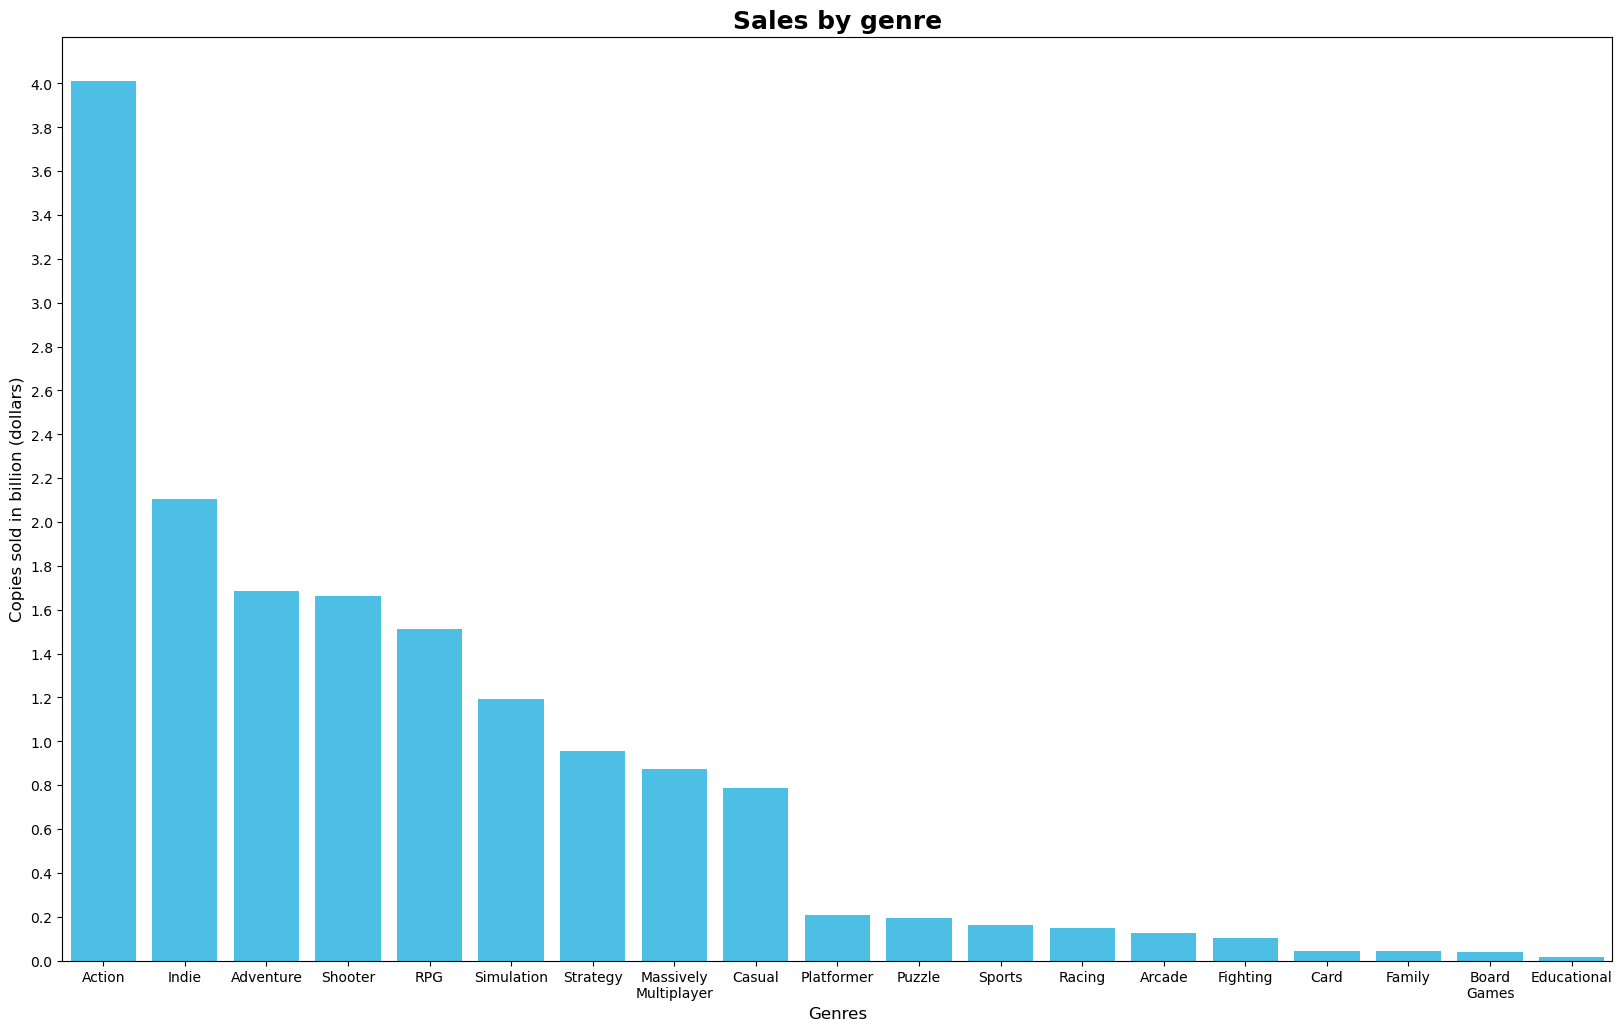

In [508]:
# Визуализируем продажи игр по их жанрам
data = []
for genre in genres:
    copiesSold = main_df[main_df[genre] == 1]['copiesSold'].sum()
    data.append({'Genre': genre, 'copiesSold': copiesSold})

genres_with_the_highest_sales = pd.DataFrame(data)
genres_with_the_highest_sales['copiesSold'] = genres_with_the_highest_sales['copiesSold'] / 1000000000
genres_with_the_highest_sales = genres_with_the_highest_sales.sort_values(by='copiesSold', ascending=False)
genres_with_the_highest_sales['Genre'] = genres_with_the_highest_sales['Genre'].str.replace(' ', '\n') # Чтобы подписи на графике выглядели ровно

plt.figure(figsize=(20, 12))
sns.barplot(data=genres_with_the_highest_sales, x='Genre', y='copiesSold', color='#00BFFF', alpha=0.8)
plt.title('Sales by genre', fontsize=18, fontweight='bold')
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Copies sold in billion (dollars)', fontsize=12)
plt.yticks(np.arange(0, 4.1, 0.2))
plt.show()

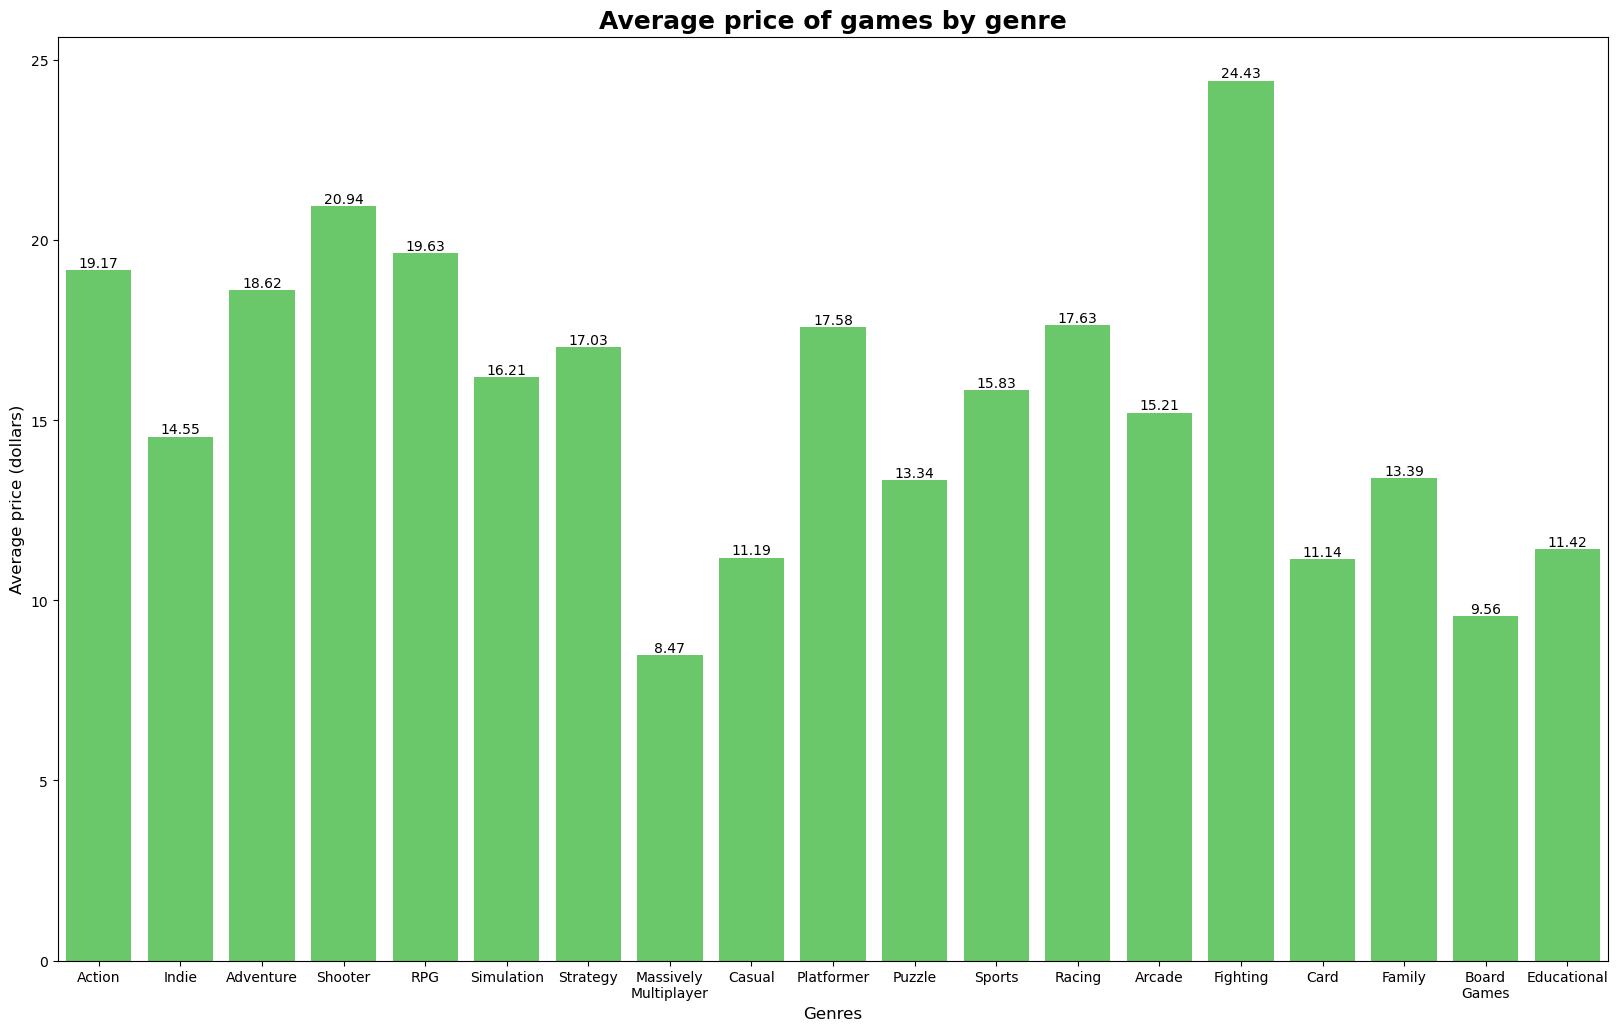

In [509]:
# Анализ цен на игры в зависимости от их жанра
data = []
for genre in genres:
    average_price = main_df[main_df[genre] == 1]['price'].mean()
    data.append({'Genre' : genre, 'average_price' : average_price})

genres_with_average_price = pd.DataFrame(data)
genres_with_average_price = genres_with_average_price.sort_values(by='average_price',ascending=False)
genres_with_average_price['Genre'] = genres_with_average_price['Genre'].str.replace(' ', '\n')

order = genres_with_the_highest_sales['Genre'].tolist()
plt.figure(figsize=(20, 12))
ax = sns.barplot(data=genres_with_average_price, x='Genre', y='average_price', color='limegreen', alpha=0.8, order=order)
for bar in ax.patches:
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), round(bar.get_height(), 2), ha='center', va='bottom')
plt.title('Average price of games by genre', fontsize=18, fontweight='bold')
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Average price (dollars)', fontsize=12)

plt.show()

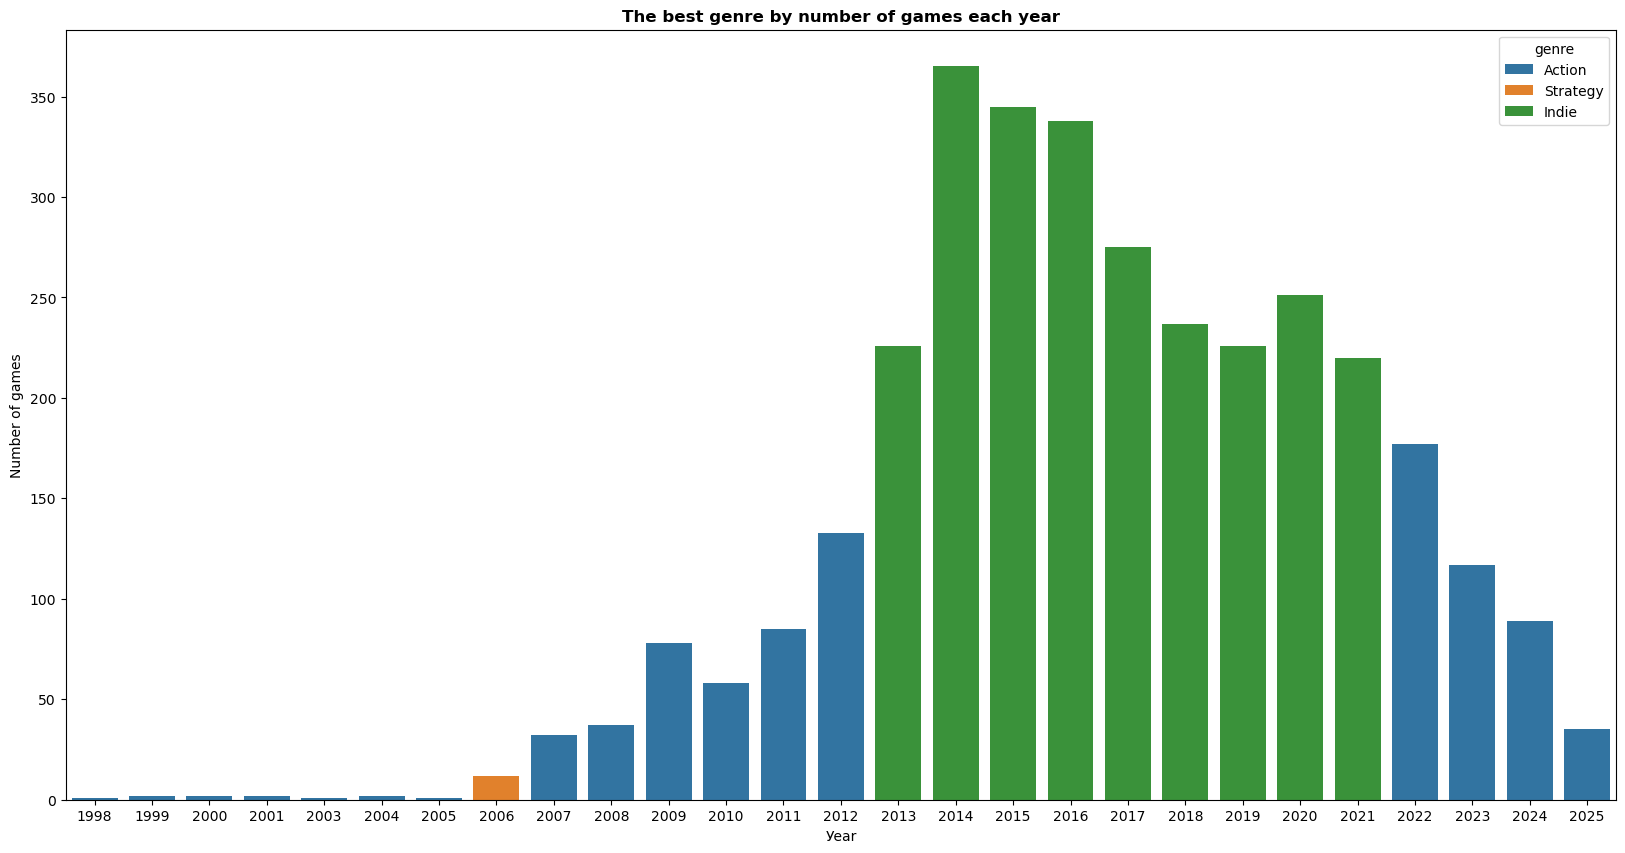

In [510]:
# Лучшие жанры по годам
genre_count_df = main_df.groupby('firstReleaseDate')[genres].sum()
top_genre_per_year = pd.DataFrame({'year': genre_count_df.index, 'genre': genre_count_df.idxmax(axis=1), 'count': genre_count_df.max(axis=1)}).reset_index(drop=True)

plt.figure(figsize=(20, 10))
sns.barplot(data=top_genre_per_year, x='year', y='count', hue='genre')
plt.title('The best genre by number of games each year', fontweight='bold')
plt.xlabel('Уear')

plt.ylabel('Number of games')
plt.show()

In [511]:
# Смотрим на то, сколько игр выпущено компаниями разного типа 'publisherClass' и сколько в среднем копий игры продается у компании каждого типа (нижний график)
summary = main_df.groupby('publisherClass')['copiesSold'].agg(['count', 'mean']).reset_index()

fig = make_subplots(rows=2, cols=1, subplot_titles=('<b>Total game count</b>', '<b>Average number of copies sold (millions)</b>'))

fig.add_trace(go.Bar(x=summary['publisherClass'], y=summary['count'], name='Count'), row=1, col=1)
fig.add_trace(go.Bar(x=summary['publisherClass'], y=summary['mean'], name='Copies Sold'), row=2, col=1)

fig.show()

In [512]:
all_classes = main_df['publisherClass'].unique() # Смотрим, какие классы компаний есть

# Проанализируем отдельно для каждого класса прибыльность игр каждого жанра
a_class = main_df[(main_df['publisherClass'] == 'AA') | (main_df['publisherClass'] == 'AAA')].reset_index()
a_class = a_class.drop(columns='index')
hob_class = main_df[main_df['publisherClass'] == 'Hobbyist'].reset_index()
hob_class = hob_class.drop(columns='index')
indie_class = main_df[main_df['publisherClass'] == 'Indie'].reset_index()
indie_class = indie_class.drop(columns='index')

def avg_rev_by_genre(df, genres):
    data = []
    for g in genres:
        games_genre = df[df[g] == 1]
        average_rev = games_genre['revenue'].mean()
        data.append({'Genre': g, 'AverageRevenue': average_rev})
    res = pd.DataFrame(data).sort_values('AverageRevenue', ascending=False)
    return res.reset_index().drop(columns='index')

rev_by_genres_aclass = avg_rev_by_genre(a_class, genres)
rev_by_genres_indie = avg_rev_by_genre(indie_class, genres)
rev_by_genres_hob = avg_rev_by_genre(hob_class, genres)
rev_by_genres_aclass['Genre'] = rev_by_genres_aclass['Genre'].str.replace(' ', '\n')
rev_by_genres_indie['Genre'] = rev_by_genres_indie['Genre'].str.replace(' ', '\n')
rev_by_genres_hob['Genre'] = rev_by_genres_hob['Genre'].str.replace(' ', '\n')

rev_by_genres_hob = rev_by_genres_hob.dropna() # Игр некоторых жанров нет в 'publisherClass' = 'Hobbyist' (получается NaN по средней выручке), просто удаляем эти строки

# Построение барчартов
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.3, row_heights=[0.4, 0.4, 0.4], subplot_titles=['<b>Average revenue by genre in A class types</b>', '<b>Average revenue by genre in Indie class type</b>', '<b>Average revenue by genre in Hobbyist class type</b>'])

fig.add_trace(go.Bar(x=rev_by_genres_aclass['Genre'], y=rev_by_genres_aclass['AverageRevenue'], name='Average revenue (millions)'), row=1, col=1)
fig.add_trace(go.Bar(x=rev_by_genres_indie['Genre'], y=rev_by_genres_indie['AverageRevenue'], name='Average revenue (millions)'), row=2, col=1)
fig.add_trace(go.Bar(x=rev_by_genres_hob['Genre'], y=rev_by_genres_hob['AverageRevenue'], name='Average revenue (millions)'), row=3, col=1)

fig.update_layout(bargap=0.3, height=500)
fig.show()

`График показывает, что самыми прибыльными жанрами для крупных издателей (AA/AAA) являются Massively Multiplayer, Shooter и RPG, в то время как у Indie и Hobbyist наибольшую прибыль приносят более простые жанры — Platformer, Action и Card`

In [513]:
data = []
for platform in prefers_platforms:
    filter = main_df[main_df[platform] == 1]
    total_sales = filter['copiesSold'].sum()
    avg_rev = filter['revenue'].mean()
    games_number = len(filter)
    data.append([platform, total_sales, avg_rev, games_number])

data = pd.DataFrame(data, columns=['platform', 'sales', 'avg_rev', 'games_number'])
data['size'] =  (data['avg_rev'] - data['avg_rev'].min()) / (data['avg_rev'].max() - data['avg_rev'].min()) # Делаем нормировку средней прибыли игр

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data['platform'],
    y=data['sales'],
    mode='markers',
    marker=dict(
        size=data['size'] * 80 + 20,
        color=data['avg_rev'],
        colorscale='Viridis',
        colorbar=dict(title='<b>The average revenue of the game<b>'),
    )
))

fig.update_layout(title='<b>Sales and average revenue of games by platform<b>', xaxis_title='<b>Platforms<b>', yaxis_title='<b>Number of game sales<b>') 
fig.show()

`График показывает, что самыми перспективными платформами являются консоли - PS5 и Xbox Series S/X, так как на данных платформах относительно малое количество конкурентов и наивысшая средняя прибыль на игру`

In [514]:
prefer_pl = ['PC', 'PlayStation 4', 'PlayStation 5', 'Xbox One', 'Xbox Series S/X']

# Проанализируем отдельно для каждого класса прибыльность игр каждого жанра
PC_pl = main_df[main_df['PC'] == 1].reset_index()
PC_pl = PC_pl.drop(columns='index')
PS4_pl = main_df[main_df['PlayStation 4'] == 1].reset_index()
PS4_pl = PS4_pl.drop(columns='index')
PS5_pl = main_df[main_df['PlayStation 5'] == 1].reset_index()
PS5_pl = PS5_pl.drop(columns='index')
XO_pl = main_df[main_df['Xbox One'] == 1].reset_index()
XO_pl = XO_pl.drop(columns='index')
XSX_pl = main_df[main_df['Xbox Series S/X'] == 1].reset_index()
XSX_pl = XSX_pl.drop(columns='index')

def avg_rev_by_platform(df, genres):
    data = []
    for g in genres:
        mask = (df[g] == 1)
        average_rev = df.loc[mask, 'revenue'].mean()
        data.append({'Genre': g, 'AverageRevenue': average_rev})
    res = pd.DataFrame(data).sort_values('AverageRevenue', ascending=False)
    return res.reset_index().drop(columns='index')

rev_by_PC = avg_rev_by_platform(PC_pl, genres)
rev_by_PS4 = avg_rev_by_platform(PS4_pl, genres)
rev_by_PS5 = avg_rev_by_platform(PS5_pl, genres)
rev_by_XO = avg_rev_by_platform(XO_pl, genres)
rev_by_XSX = avg_rev_by_platform(XSX_pl, genres)
rev_by_PC['Genre'] = rev_by_PC['Genre'].str.replace(' ', '\n')
rev_by_PS5['Genre'] = rev_by_PS5['Genre'].str.replace(' ', '\n')
rev_by_PS4['Genre'] = rev_by_PS4['Genre'].str.replace(' ', '\n')
rev_by_XO['Genre'] = rev_by_XO['Genre'].str.replace(' ', '\n')
rev_by_XSX['Genre'] = rev_by_XSX['Genre'].str.replace(' ', '\n')

# Построение барчартов
fig = make_subplots(rows=5, cols=1, row_heights=[0.4, 0.4, 0.4, 0.4, 0.4], 
                    subplot_titles=['<b>Average revenue by genres on PC platform</b>', 
                                    '<b>Average revenue by genres on PS4 platform</b>', 
                                    '<b>Average revenue by genres on PS5 platform</b>', 
                                    '<b>Average revenue by genres on Xbox One platform</b>',
                                     '<b>Average revenue by genres on Xbox Series S/X</b>'
                                    ])

fig.add_trace(go.Bar(x=rev_by_PC['Genre'], y=rev_by_PC['AverageRevenue'], name='Average revenue (millions)'), row=1, col=1)
fig.add_trace(go.Bar(x=rev_by_PS4['Genre'], y=rev_by_PS4['AverageRevenue'], name='Average revenue (millions)'), row=2, col=1)
fig.add_trace(go.Bar(x=rev_by_PS5['Genre'], y=rev_by_PS5['AverageRevenue'], name='Average revenue (millions)'), row=3, col=1)
fig.add_trace(go.Bar(x=rev_by_XO['Genre'], y=rev_by_XO['AverageRevenue'], name='Average revenue (millions)'), row=4, col=1)
fig.add_trace(go.Bar(x=rev_by_XSX['Genre'], y=rev_by_XSX['AverageRevenue'], name='Average revenue (millions)'), row=5, col=1)

fig.update_layout(bargap=0.3, height=1000)
fig.show()

`Наиболее прибыльными жанрами на различных платформах являются шутеры, мультиплееры, РПГ и карточные игры`

Корелляция (Пирсона) между рейтингой и выручкой фильма: 0.44200999940963515


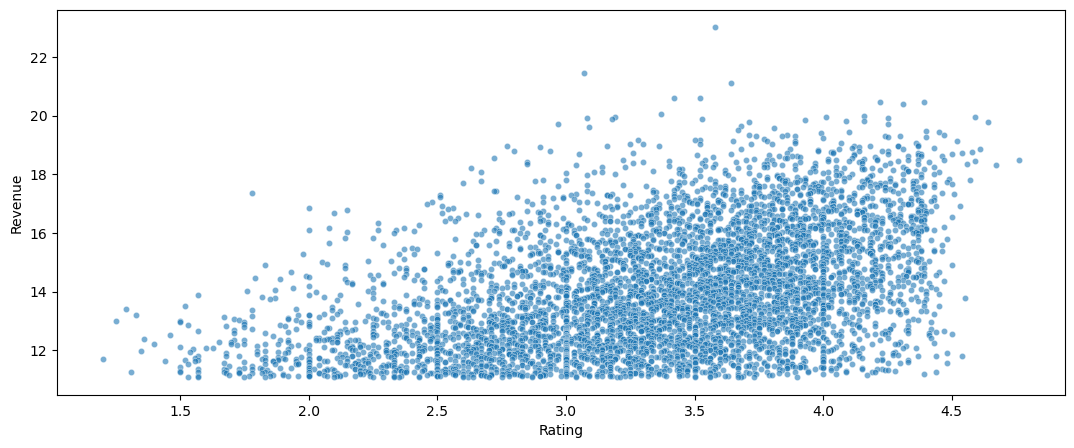

In [515]:
lg_r = pd.DataFrame()
lg_r['rating'] = main_df['rating']
lg_r['lg_revenue'] = np.log1p(main_df['revenue'])

print('Корелляция (Пирсона) между рейтингой и выручкой фильма:', lg_r['lg_revenue'].corr(lg_r['rating']))

plt.figure(figsize=(13,5))
sns.scatterplot(data=lg_r, x='rating', y='lg_revenue', alpha=0.6, s=20)
plt.xlabel('Rating')
plt.ylabel('Revenue')

plt.show()

In [516]:
genres = ['Action', 'Adventure', 'Arcade', 'Board Games', 'Card', 'Casual', 'Educational', 'Family', 'Fighting', 'Indie', 'Massively Multiplayer', 'Platformer', 'Puzzle', 'RPG', 'Racing', 'Shooter', 'Simulation', 'Sports', 'Strategy']

data = []
for genre in genres:
    filter = main_df[main_df[genre] == 1]
    avg_rating = filter['rating'].mean()
    avg_rev = filter['revenue'].mean()
    games_number = len(filter)
    data.append([genre, avg_rating, avg_rev, games_number])

data = pd.DataFrame(data, columns=['genre', 'avg_rating', 'avg_rev', 'games_number'])
data['size'] = (data['avg_rev'] - data['avg_rev'].min()) / (data['avg_rev'].max() - data['avg_rev'].min())

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data['genre'],
    y=data['avg_rating'],
    mode='markers',
    marker=dict(
        size=data['size'] * 80 + 20,
        color=data['avg_rev'],
        colorscale='Viridis',
        colorbar=dict(title='<b>Average revenue<b>'),
    )
))

fig.update_layout(title='<b>Average rating and revenue by genres<b>',
                  xaxis_title='<b>Genres<b>',
                  yaxis_title='<b>Average rating<b>')
fig.show()
